# SIRD Model

Basic SIRD model for Indonesia Covid 
(data until 20200326)

![SIRD](../images/Scheme-of-Susceptible-Infectious-Recovered-Death-SIRD-Model-Boxes-represent.png)

In [1]:
import pandas as pd
import scipy.integrate as spi
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
PATH_DATA = '../data/raw/'

In [3]:
## Assumption
NUMB_OF_POPS=30000000

## Get The Data

Getting the data and do the summary

In [4]:
df_daily=pd.read_csv(PATH_DATA+'20200326_DailyCase_ID.csv')

In [5]:
df_daily

,DT,Kasus (Kumulatif),Kasus Baru,Sembuh (baru),Meninggal (baru)
0,2020-03-02 00:00:00,2,2.0,NaN,NaN
1,2020-03-03 00:00:00,2,NaN,NaN,NaN
2,2020-03-04 00:00:00,2,NaN,NaN,NaN
3,2020-03-05 00:00:00,2,NaN,NaN,NaN
4,2020-03-06 00:00:00,4,2.0,NaN,NaN
5,2020-03-07 00:00:00,4,NaN,NaN,NaN
6,2020-03-08 00:00:00,6,2.0,NaN,NaN
7,2020-03-09 00:00:00,19,13.0,NaN,NaN
8,2020-03-10 00:00:00,27,8.0,NaN,NaN
9,2020-03-11 00:00:00,34,7.0,2.0,2.0


In [6]:
df_daily=df_daily.fillna(0)

In [7]:
df_daily['Inf']=df_daily['Kasus (Kumulatif)']-df_daily['Sembuh (baru)']-df_daily['Meninggal (baru)']
df_daily['Sus']=NUMB_OF_POPS-df_daily['Inf']
df_daily['Rec']=df_daily['Sembuh (baru)']
df_daily['Dea']=df_daily['Meninggal (baru)']
col_use=['Sus','Inf','Rec','Dea']


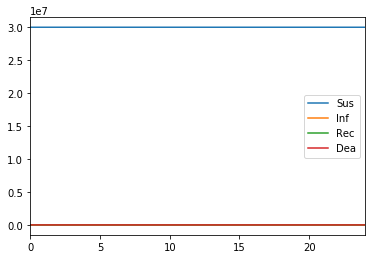

In [8]:
df_daily[col_use].plot()

In [9]:
df_daily[col_use].head()

,Sus,Inf,Rec,Dea
0,29999998.0,2.0,0.0,0.0
1,29999998.0,2.0,0.0,0.0
2,29999998.0,2.0,0.0,0.0
3,29999998.0,2.0,0.0,0.0
4,29999996.0,4.0,0.0,0.0


## Define SIRD Model

![SIRD derivative funtion](../images/SIRD-Model.png)

In [10]:
def sird_model_diff(VALUE_ON_T,t):  
    '''The main set of equations'''
    Y=np.zeros((4))
    dS,dI,dR,dD = VALUE_ON_T  
    Y[0] = - param_b * dS * dI
    Y[1] = (param_b * dS * dI) - (param_r * dI) - (param_m * dI)
    Y[2] = param_r * dI
    Y[3] = param_m * dI
    
    return Y   # For odeint

## Determine the Parameter

using simple linear regression

In [11]:
df_daily[col_use].head(10)

,Sus,Inf,Rec,Dea
0,29999998.0,2.0,0.0,0.0
1,29999998.0,2.0,0.0,0.0
2,29999998.0,2.0,0.0,0.0
3,29999998.0,2.0,0.0,0.0
4,29999996.0,4.0,0.0,0.0
5,29999996.0,4.0,0.0,0.0
6,29999994.0,6.0,0.0,0.0
7,29999981.0,19.0,0.0,0.0
8,29999973.0,27.0,0.0,0.0
9,29999970.0,30.0,2.0,2.0


In [12]:
for cc in col_use:
    df_daily[cc+'_before']=df_daily[cc].shift(1)
    df_daily[cc+'_dt']=df_daily[cc]-df_daily[cc+'_before']

In [13]:
col_use_t=['Sus_dt','Inf_dt','Rec_dt','Dea_dt']

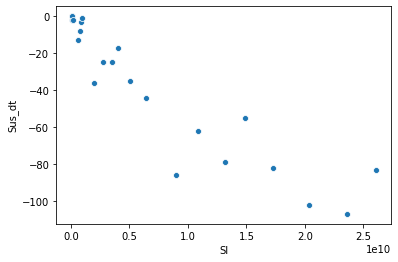

In [14]:
## param_b
# Y[0] = - param_b * dS * dI
df_daily['SI']=df_daily['Sus']*df_daily['Inf']
sns.scatterplot(data=df_daily[['Sus_dt','SI']],x='SI',y='Sus_dt')

In [15]:
param_b_df=df_daily[['Sus_dt','SI']]
param_b_df.head()

,Sus_dt,SI
0,NaN,59999996.0
1,0.0,59999996.0
2,0.0,59999996.0
3,0.0,59999996.0
4,-2.0,119999984.0


In [16]:
param_b_df=param_b_df.dropna()

In [17]:
param_b_mod = sm.GLS(param_b_df['Sus_dt'],param_b_df['SI'])
param_b_res = param_b_mod.fit()
param_b_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 GLS Regression Results                                
=======================================================================================
Dep. Variable:                 Sus_dt   R-squared (uncentered):                   0.911
Model:                            GLS   Adj. R-squared (uncentered):              0.907
Method:                 Least Squares   F-statistic:                              235.4
Date:                Fri, 27 Mar 2020   Prob (F-statistic):                    1.43e-13
Time:                        09:00:31   Log-Likelihood:                         -99.353
No. Observations:                  24   AIC:                                      200.7
Df Residuals:                      23   BIC:                                      201.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SI         -4.623e-09   3.01e-10    -15.341      0.000   -5.25e-09      -4e-09
==============================================================================
Omnibus:                        6.792   Durbin-Watson:                   1.122
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                8.326
Skew:                           0.082   Prob(JB):                       0.0156
Kurtosis:                       5.881   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
param_b=abs(param_b_res.params['SI'])
param_b

4.6230151871351355e-09

In [19]:
range_param_b=param_b_res.conf_int(alpha=0.05, cols=None)
range_param_b=range_param_b.values[0]
param_b_max=abs(range_param_b[0])
param_b_min=abs(range_param_b[1])
param_b_pvalues=param_b_res.pvalues.values[0]

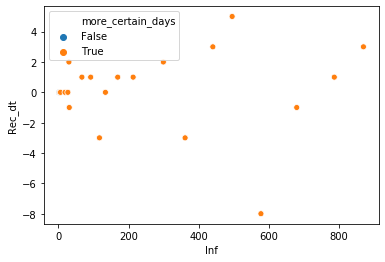

In [20]:
## param_r
# Y[2] = param_r * dI
df_daily['days']=[i for i in range(len(df_daily))]
df_daily['more_certain_days']=(df_daily['days']>4)
sns.scatterplot(data=df_daily[['Rec_dt','Inf','more_certain_days']],x='Inf',y='Rec_dt',hue='more_certain_days')

In [21]:
param_r_df=df_daily[df_daily.more_certain_days][['Rec_dt','Inf']]
param_r_df

,Rec_dt,Inf
5,0.0,4.0
6,0.0,6.0
7,0.0,19.0
8,0.0,27.0
9,2.0,30.0
10,-1.0,31.0
11,1.0,67.0
12,1.0,92.0
13,-3.0,117.0
14,0.0,134.0


In [22]:
param_r_mod = sm.GLS(param_r_df['Rec_dt'],param_r_df['Inf'])
param_r_res = param_r_mod.fit()
param_r_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 GLS Regression Results                                
=======================================================================================
Dep. Variable:                 Rec_dt   R-squared (uncentered):                   0.006
Model:                            GLS   Adj. R-squared (uncentered):             -0.046
Method:                 Least Squares   F-statistic:                             0.1227
Date:                Fri, 27 Mar 2020   Prob (F-statistic):                       0.730
Time:                        09:01:31   Log-Likelihood:                         -47.774
No. Observations:                  20   AIC:                                      97.55
Df Residuals:                      19   BIC:                                      98.54
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inf            0.0006      0.002      0.350      0.730      -0.003       0.004
==============================================================================
Omnibus:                       13.880   Durbin-Watson:                   2.405
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.300
Skew:                          -1.369   Prob(JB):                      0.00129
Kurtosis:                       5.909   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
param_r=param_r_res.params['Inf']
param_r

0.0005521234014466514

In [24]:
range_param_r=param_r_res.conf_int(alpha=0.05, cols=None)
range_param_r=range_param_r.values[0]
param_r_max=range_param_r[1]
param_r_min=max(0,range_param_r[0])
param_r_pvalues=param_r_res.pvalues.values[0]

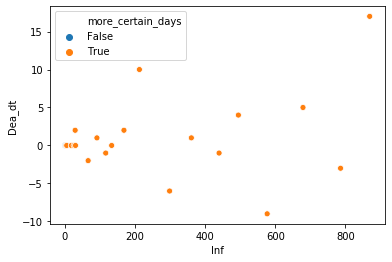

In [25]:
## param_m
# Y[3] = param_m * dI
sns.scatterplot(data=df_daily[['Dea_dt','Inf','more_certain_days']],x='Inf',y='Dea_dt',hue='more_certain_days')

In [26]:
param_m_df=df_daily[df_daily.more_certain_days][['Dea_dt','Inf']]
param_m_df

,Dea_dt,Inf
5,0.0,4.0
6,0.0,6.0
7,0.0,19.0
8,0.0,27.0
9,2.0,30.0
10,0.0,31.0
11,-2.0,67.0
12,1.0,92.0
13,-1.0,117.0
14,0.0,134.0


In [27]:
param_m_mod = sm.GLS(param_m_df['Dea_dt'],param_m_df['Inf'])
param_m_res = param_m_mod.fit()
param_m_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 GLS Regression Results                                
=======================================================================================
Dep. Variable:                 Dea_dt   R-squared (uncentered):                   0.102
Model:                            GLS   Adj. R-squared (uncentered):              0.054
Method:                 Least Squares   F-statistic:                              2.151
Date:                Fri, 27 Mar 2020   Prob (F-statistic):                       0.159
Time:                        09:01:33   Log-Likelihood:                         -60.840
No. Observations:                  20   AIC:                                      123.7
Df Residuals:                      19   BIC:                                      124.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inf            0.0044      0.003      1.467      0.159      -0.002       0.011
==============================================================================
Omnibus:                        4.554   Durbin-Watson:                   2.436
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                2.608
Skew:                           0.419   Prob(JB):                        0.271
Kurtosis:                       4.558   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
param_m=param_m_res.params['Inf']
param_m

0.004443117206601728

In [29]:
range_param_m=param_m_res.conf_int(alpha=0.05, cols=None)
range_param_m=range_param_m.values[0]
param_m_max=range_param_m[1]
param_m_min=max(0,range_param_m[0])
param_m_pvalues=param_m_res.pvalues.values[0]

In [30]:
# param_b_max*100000000,param_b_min*100000000

In [33]:
## param_r and param_m
# Y[1] = (param_b * dS * dI) - (param_r * dI) - (param_m * dI)
param_rm_df=df_daily[['Inf_dt','SI','Inf']]
param_rm_df=param_rm_df.dropna()
param_rm_mod = sm.GLS(param_rm_df['Inf_dt'],param_rm_df[['SI','Inf']])
param_rm_res = param_rm_mod.fit()
param_rm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 GLS Regression Results                                
=======================================================================================
Dep. Variable:                 Inf_dt   R-squared (uncentered):                   0.958
Model:                            GLS   Adj. R-squared (uncentered):              0.954
Method:                 Least Squares   F-statistic:                              250.2
Date:                Fri, 27 Mar 2020   Prob (F-statistic):                    7.38e-16
Time:                        09:02:40   Log-Likelihood:                         -90.369
No. Observations:                  24   AIC:                                      184.7
Df Residuals:                      22   BIC:                                      187.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SI             0.0002   3.22e-05      4.951      0.000    9.26e-05       0.000
Inf        -4778.0526    965.076     -4.951      0.000   -6779.498   -2776.607
==============================================================================
Omnibus:                        4.094   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.129   Jarque-Bera (JB):                2.735
Skew:                           0.228   Prob(JB):                        0.255
Kurtosis:                       4.590   Cond. No.                     4.55e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.55e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
param_rm_res.conf_int(alpha=0.05, cols=None)

,0,1
SI,0.000093,0.000226
Inf,-6779.498322,-2776.606878


In [29]:
param_b, param_r, param_m

(6.934384162282657e-10, 0.0005521234014466514, 0.004443117206601728)

In [30]:
print('param b range :',param_b_max,param_b_min,param_b_pvalues)
print('param r range :',param_r_max,param_r_min,param_r_pvalues)
print('param m range :',param_m_max,param_m_min,param_m_pvalues)

param b range : 7.869447902250199e-10 5.999320422315115e-10 1.4270265889477365e-13
param r range : 0.003851166061241754 0 0.7299776276508135
param m range : 0.010783710116135135 0 0.15882299253527699


In [56]:
param_bo = param_b_min
param_ro = param_r_max
param_mo = param_m_min+0.001

## Running SIRD Model

In [47]:
def sird_model_diff(VALUE_ON_T,t):  
    '''The main set of equations'''
    Y=np.zeros((4))
    dS,dI,dR,dD = VALUE_ON_T  
    Y[0] = - param_bo * dS * dI
    Y[1] = (param_bo * dS * dI) - (param_ro * dI) - (param_mo * dI)
    Y[2] = param_ro * dI
    Y[3] = param_mo * dI
    
    return Y   # For odeint

In [53]:
T_start = 0.0
T_inc=1.0
T_end=30.0*30
I0=2
S0=NUMB_OF_POPS-I0
INPUT = (S0, I0, 0.0, 0.0)

T_range = np.arange(T_start, T_end+T_inc, T_inc)
RES = spi.odeint(sird_model_diff,INPUT,T_range)

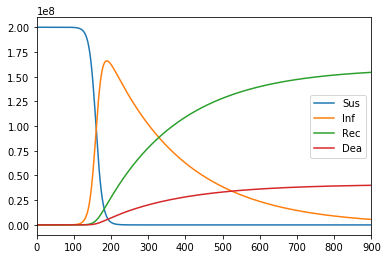

In [54]:
# pd.DataFrame(RES,columns=['Sus','Inf','Rec','Dea'])[['Inf','Rec','Dea']].plot()
pd.DataFrame(RES,columns=['Sus','Inf','Rec','Dea']).plot()

In [50]:
# pd.DataFrame(RES,columns=['Sus','Inf','Rec','Dea'])

## Interactive

## Reference
    
    Data : https://kawalcovid19.blob.core.windows.net/viz/statistik_harian.html
    
    Source Script : http://epirecip.es/epicookbook/chapters/kr08/2_1/python_original
    
    Image 1 : https://www.researchgate.net/figure/Scheme-of-Susceptible-Infectious-Recovered-Death-SIRD-Model-Boxes-represent_fig1_41507287
    
    Image 2 : https://www.chegg.com/homework-help/questions-and-answers/codes-problem-code-1-function-siddeterm-simulation-deterministic-sird-model-using-differen-q21316613